# BRDF fitting and rendering

In this notebook, we will fit BRDFs to the processed images. The BRDFs will be rendered to check if they are faithful to the captured images and also quantiatively evaluated


In [231]:
import os
os.environ['OPENCV_IO_ENABLE_OPENEXR'] = '1'
import torch
import cv2
import imageio
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from ipywidgets import *
from torch import nn
import scipy.optimize
import imageio.v3 as iio
from ipywidgets import interact

In [232]:
# Height & Width of the Grid
H, W = 256, 256
ball_radius = 18  # Replace this with the size of your sphere in mm
light_dist = 1000 / ball_radius  # Distance of the light from the object
camera_dist = 1850 / ball_radius  # Distance of the Camera from the object

print(f"Light Distance: {light_dist}, Camera Distance: {camera_dist}")


Light Distance: 55.55555555555556, Camera Distance: 102.77777777777777


In [233]:

# Assuming H and W define the grid size of the rendered sphere
y, x = np.meshgrid(np.linspace(-1, 1, H), np.linspace(-1, 1, W))

# Define the mask to identify the pixels on the sphere surface (unit sphere centered at origin)
in_frame = x**2 + y**2 <= 1

# Calculate z values based on x, y, assuming the sphere's surface equation x^2 + y^2 + z^2 = 1
z = np.sqrt(1 - x**2 - y**2)
z[~in_frame] = 0  # Set z=0 for pixels outside the sphere

# Calculate normals for each point on the sphere surface
normals = np.stack((x, y, z), axis=-1)
normals /= np.linalg.norm(normals, axis=-1, keepdims=True)  # Normalize the normals

# Subset normals within the frame for rendering
normals_in_frame = normals[in_frame]

C:\Users\Sayedur\AppData\Local\Temp\ipykernel_6544\1295633109.py:8: RuntimeWarning: invalid value encountered in sqrt
  z = np.sqrt(1 - x**2 - y**2)


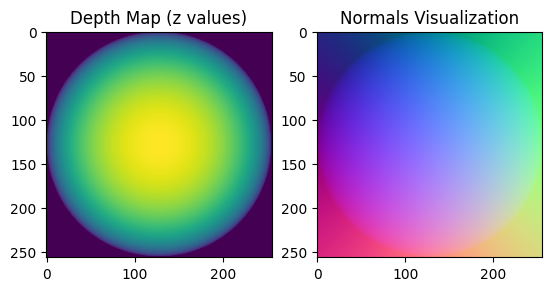

In [234]:
plt.subplot(1, 2, 1)
plt.imshow(z, cmap="viridis")  # Color map can enhance visibility
plt.title("Depth Map (z values)")

plt.subplot(1, 2, 2)
plt.imshow(normals / 2 + 0.5)  # Shifted and scaled to [0, 1]
plt.title("Normals Visualization")

plt.show()


First, we define a simple BRDF model. Each BRDF instance should be callable, with two arguments: w_i, and w_o, which are the normalized vectors (omegas) describing the incident and and viewing directions respectively. The idea is to calculate the BRDF for all the points of the sphere at once (vectorized implementation) instead of finding the BRDF value for each point over a loop.

In [235]:
class LambertianBRDF:
    # Simple Lambertian BRDF model for a virtual object (e.g., green color)
    def __init__(self, diffuse_color=(1.0, 0.0, 0.0)):
        self.diffuse_color = np.array(diffuse_color)  # Set diffuse color

    def __call__(self, w_i: np.ndarray, w_o: np.ndarray) -> np.ndarray:
        # Calculate the cosine term (dot product of w_i and surface normal)
        cos_theta = np.clip(w_i[..., 2], 0, 1)  # Cosine of angle with surface normal along z-axis
        # Return the diffuse color modulated by the cosine term for all points
        return self.diffuse_color * cos_theta[..., np.newaxis]


In [236]:
class PhongBRDF:
    def __init__(self, diffuse_color=(1.0, 0.0, 0.0), specular_color=(1.0, 1.0, 1.0), alpha=20.0):
        self.diffuse_color = np.array(diffuse_color)
        self.specular_color = np.array(specular_color)
        self.alpha = alpha  # Shininess coefficient

    def __call__(self, w_i: np.ndarray, w_o: np.ndarray) -> np.ndarray:
        # Calculate diffuse term as in Lambertian model
        cos_theta = np.clip(w_i[..., 2], 0, 1)  # Cosine term with normal (z-component)
        diffuse = self.diffuse_color * cos_theta[..., np.newaxis]

        # Calculate specular term
        h = normalize(w_i + w_o)  # Halfway vector between w_i and w_o
        cos_alpha = np.clip(h[..., 2], 0, 1)  # Dot product with normal (z-component)
        specular = self.specular_color * (cos_alpha ** self.alpha)[..., np.newaxis]

        # Return combined diffuse and specular terms
        return diffuse + specular

In [237]:
def normalize(v):
    """ Utility function that normalizes a vector. Expects shape ... x 3 """
    return v / np.linalg.norm(v, axis=-1, keepdims=True)



In [238]:
def get_rotations(a, b=(0.0, 0.0, 1.0)):
    """ Utility function that computes the rotation to bring vector _a_ to direction _b_.
        `a` is expected to have shape (B, 3).
    """
    # Ensure `b` has the same shape as `a`
    b = np.tile(b, (a.shape[0], 1))
    
    # Calculate the cross product and cosine of the angle between vectors
    v = np.cross(a, b)  # Cross product: shape (B, 3)
    cos = np.einsum('ij,ij->i', a, b)  # Dot product to get cos(theta), shape: (B,)
    
    # Skew-symmetric matrix for cross product
    skew = np.zeros((a.shape[0], 3, 3))
    skew[:, 0, 1] = -v[:, 2]
    skew[:, 0, 2] = v[:, 1]
    skew[:, 1, 0] = v[:, 2]
    skew[:, 1, 2] = -v[:, 0]
    skew[:, 2, 0] = -v[:, 1]
    skew[:, 2, 1] = v[:, 0]
    
    # Identity matrix of shape (B, 3, 3)
    i = np.eye(3)[None, :, :].repeat(a.shape[0], axis=0)
    
    # Calculate the rotation matrices
    rotations = i + skew + np.einsum('bij,bjk->bik', skew, skew) * (1 / (1 + cos[:, None, None]))
    
    return rotations  # Shape: (B, 3, 3)



In [239]:

def render_sphere_image(brdf, light_angle: float):
    """
    Returns the rendered sphere given a light direction.
    light_angle: float giving the light direction in degrees.
    """
    # Convert light angle to radians
    light_angle = np.deg2rad(light_angle)

    # Light and camera positions
    light_pos = light_dist * np.array([0, np.sin(light_angle), np.cos(light_angle)])
    camera_pos = camera_dist * np.array([0, 0, 1])

    # Define the sphere's x, y grid if not already defined globally
    global x, y, in_frame
    if 'x' not in globals() or 'y' not in globals():
        y, x = np.meshgrid(np.linspace(-1, 1, H), np.linspace(-1, 1, W))
        in_frame = x**2 + y**2 <= 1  # Mask for points on the unit sphere

    # Calculate z based on the sphere equation, assuming z=0 at the center
    z = np.zeros_like(x)
    z[in_frame] = np.sqrt(1 - x[in_frame]**2 - y[in_frame]**2)

    # Stack x, y, z into points and normals for points within the sphere
    points = np.stack([x[in_frame], y[in_frame], z[in_frame]], axis=-1)
    normals = np.stack([x[in_frame], y[in_frame], z[in_frame]], axis=-1)
    normals /= np.linalg.norm(normals, axis=-1, keepdims=True)  # Normalize normals

    # Calculate direction vectors
    dir_to_light = normalize(light_pos - points)
    dir_to_camera = normalize(camera_pos - points)

    # Compute rotation matrices
    rotations = get_rotations(normals)
    w_i = np.einsum('bij,bj->bi', rotations, dir_to_light)
    w_o = np.einsum('bij,bj->bi', rotations, dir_to_camera)
    cos = np.einsum('bi,bi->b', dir_to_light, normals)[:, np.newaxis]

    # BRDF output, scaled by cosine factor
    light_out = brdf(w_i, w_o) * cos
    light_out_full = np.zeros((H, W, 3))  # Create a full-sized image
    light_out_full[in_frame] = light_out  # Place output in valid pixels only
    light_out_full[~in_frame] = np.nan  # Mask pixels outside the sphere

   
    return light_out_full

In [240]:
def linear_to_srgb(img):
    limit = 0.0031308
    img = np.clip(img, 0, None)  # Ensure all values are non-negative
    return np.where(img > limit, 1.055 * (img ** (1.0 / 2.4)) - 0.055, 12.92 * img)


def plot_hdr(image, title=None):
    srgb = linear_to_srgb(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')
    plt.imshow(np.clip(srgb, 0, 1))



def create_render(brdf):
    def render(light_angle):
        image = render_sphere_image(brdf, light_angle)
        plt.figure(figsize=(6, 6))
        plt.title("Rendered BRDF")
        plt.axis('off')
        plot_hdr(image)
    return render



In [241]:
brdf = PhongBRDF()
interact(create_render(brdf), light_angle=(-120, 120, 1.0));


interactive(children=(FloatSlider(value=0.0, description='light_angle', max=120.0, min=-120.0, step=1.0), Outp…

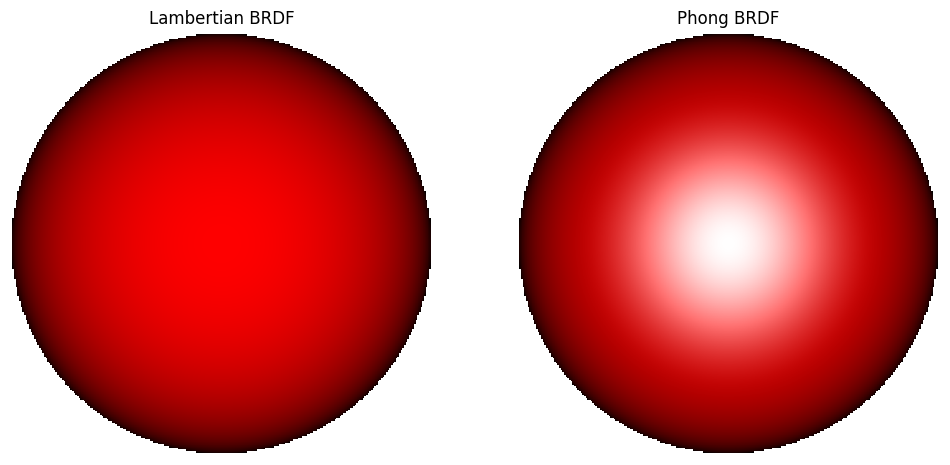

In [242]:
plt.figure(figsize=(12, 6))

# Render and plot Lambertian BRDF
plt.subplot(1, 2, 1)
result = render_sphere_image(LambertianBRDF(), 0.0)  # Render with Lambertian model
plot_hdr(result, "Lambertian BRDF")

# Render and plot Phong BRDF
plt.subplot(1, 2, 2)
result = render_sphere_image(PhongBRDF(), 0.0)  # Render with Phong model
plot_hdr(result, "Phong BRDF")

plt.show()


## Load data
We defined and render static, manually adjusted BRDFs. Now will try to infere BRDFs from data.

In [264]:
from pathlib import Path
import imageio.v3 as iio
import numpy as np
import cv2

# Define gamma correction function
def apply_gamma_correction(image, gamma=2.2):
    """Applies gamma correction to the image."""
    return np.clip(np.power(image, 1 / gamma), 0, 1)

# Define the base directory where the images are stored
data_dir = Path("C:/Users/Sayedur/Desktop/GenMat_project/ProvidedCapture_01/crops")
'''data_dir = Path("C:/Users/Sayedur/Desktop/GenMat_project/sa_ju_captured_data/HDR/crops")'''

# Define angles from 10 to 180 with intervals of 10
angles = list(range(5, 171, 15))
'''angles = list(range(10, 181, 10))'''

# Generate paths for each angle
paths = [data_dir / f"angle_{angle}.exr" for angle in angles]

# Ensure there are at least 4 images and all paths exist
assert len(paths) > 3 and all(p.exists() for p in paths), "Some image paths do not exist or there are fewer than 4 images."

# Load and resize HDR images using imageio, apply gamma correction
H, W = 256, 256
hdr_crops = [
    apply_gamma_correction(cv2.resize(iio.imread(str(path)), (H, W)))
    for path in paths
]

# Verify that images have been loaded correctly
print(f"Loaded {len(hdr_crops)} images with shape {hdr_crops[0].shape} (H, W, Channels)")


Loaded 12 images with shape (256, 256, 3) (H, W, Channels)


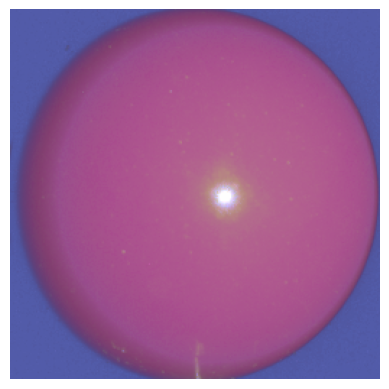

In [265]:
plot_hdr(hdr_crops[1])
'''plt.savefig("Original_01.png", dpi=300, bbox_inches="tight")''' #Original_01 for our captured data
plt.savefig("Original_02.png", dpi=300, bbox_inches="tight")# Original_02 for our provided data

In [266]:
def collect_brdf_data(input_image, light_angle=0.0, cos_eps=0.01):
    """
    Aggregates BRDF information from the input image for a given light angle and reliability threshold.
    
    Parameters:
    - input_image: np.array of shape (H, W, C), the HDR image with pixel intensities.
    - light_angle: float, the angle of the light direction in degrees.
    - cos_eps: float, threshold for cosine values to filter unreliable data.
    
    Returns:
    - w_i: np.array of shape B x 3, incoming light directions.
    - w_o: np.array of shape B x 3, outgoing directions to the camera.
    - values: np.array of shape B x 3, the BRDF values.
    """
    # Convert light angle to radians and calculate light position
    light_angle_rad = np.deg2rad(light_angle)
    light_pos = light_dist * np.array([0, np.sin(light_angle_rad), np.cos(light_angle_rad)])
    camera_pos = camera_dist * np.array([0, 0, 1])

    # Points and normals on the sphere
    points = np.stack([x[in_frame], y[in_frame], z[in_frame]], axis=-1)  # B x 3
    normals_in_frame = normals[in_frame]  # B x 3 for masked pixels

    # Directions to the light and camera, normalized
    dir_to_light = normalize(light_pos - points)
    dir_to_camera = normalize(camera_pos - points)

    # Cosine of the angle between the light direction and normals
    cos_theta = np.einsum('ij,ij->i', dir_to_light, normals_in_frame)

    # Apply the cosine threshold to filter unreliable pixels
    reliable_pixels = cos_theta > cos_eps

    # Collect BRDF data from reliable pixels
    w_i = dir_to_light[reliable_pixels]
    w_o = dir_to_camera[reliable_pixels]
    values = input_image[in_frame][reliable_pixels]  # Pixel intensities (B x 3)


    return w_i, w_o, values


In [267]:
# Initialize lists to store collected w_i, w_o, and values from each image
w_i_list = []
w_o_list = []
values_list = []

# Loop through each angle and corresponding HDR image
for angle, hdr_crop in zip(angles, hdr_crops):
    # Collect w_i, w_o, and BRDF values from the current image
    w_i, w_o, values = collect_brdf_data(hdr_crop, light_angle=angle, cos_eps=0.01)
    
    # Append the collected data to lists
    w_i_list.append(w_i)
    w_o_list.append(w_o)
    values_list.append(values)

# Concatenate all collected data into final arrays
w_i = np.concatenate(w_i_list, axis=0)
w_o = np.concatenate(w_o_list, axis=0)
values = np.concatenate(values_list, axis=0)


# Verify the shapes
print(f"w_i shape: {w_i.shape}, w_o shape: {w_o.shape}, values shape: {values.shape}")


w_i shape: (307778, 3), w_o shape: (307778, 3), values shape: (307778, 3)


In [268]:
assert w_i.shape == w_o.shape == values.shape

In [269]:
class LambertianFitBRDF():
    def __init__(self):
        super().__init__()
        self.model = LambertianBRDF()
        self.params = np.array(self.model.diffuse_color)
        self.result = None
    
    def run(self, params, w_i, w_o):
        self.model.diffuse_color = params[:3]
        return self.model(w_i, w_o)

    def objective(self, params, w_i, w_o, values):
        prediction = self.run(params, w_i, w_o)
        return np.mean((prediction - values) ** 2)

    def fit(self, w_i, w_o, values):
        self.result = scipy.optimize.minimize(self.objective, x0=self.params, args=(w_i, w_o, values))
        self.params = self.result.x
        return self

    def __call__(self, w_i: np.ndarray, w_o: np.ndarray) -> np.ndarray:
        return self.run(self.params, w_i, w_o)

In [270]:
fitted_brdf = LambertianFitBRDF().fit(w_i, w_o, values)

In [271]:
interact(create_render(fitted_brdf), light_angle=(-120, 120, 1.0))


interactive(children=(FloatSlider(value=0.0, description='light_angle', max=120.0, min=-120.0, step=1.0), Outp…

<function __main__.create_render.<locals>.render(light_angle)>

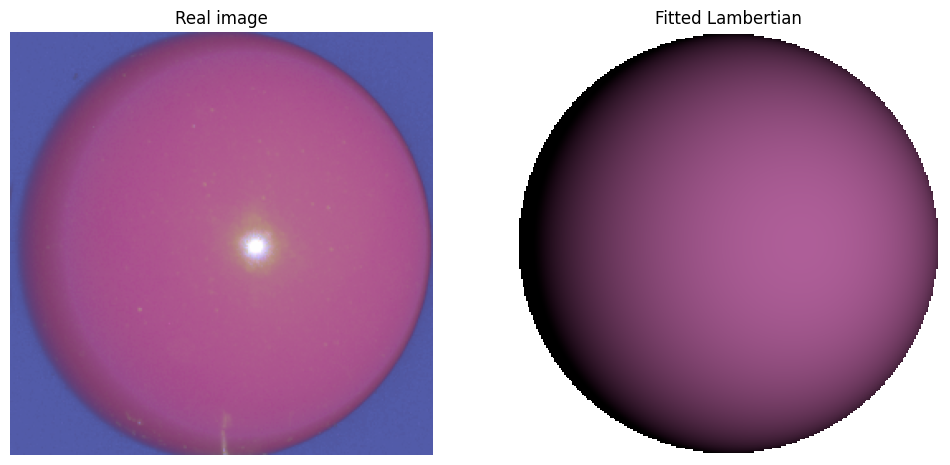

In [272]:
idx = 1  # Index to select the HDR image and corresponding angle
plt.figure(figsize=(12, 6))

# Plot the real image
plt.subplot(1, 2, 1)
plot_hdr(hdr_crops[idx], title="Real image")

# Plot the fitted Lambertian rendering
plt.subplot(1, 2, 2)
rendered_image = render_sphere_image(fitted_brdf, angles[idx])
plot_hdr(rendered_image, title="Fitted Lambertian")


Similar to the LambertianFitBRDF, you are required to provide the code for the methods of the PhongFitBRDF

In [273]:
class PhongFitBRDF():
    def __init__(self):
        self.diffuse_color = np.array([0.0, 1.0, 0.0])  # Default to green
        self.specular_color = np.array([1.0, 1.0, 1.0])  # Default to white
        self.alpha = 20.0  # Shininess factor
        self.params = np.concatenate((self.diffuse_color, self.specular_color, [self.alpha]))
        self.result = None

    def run(self, params, w_i, w_o):
        # Unpack parameters
        diffuse_color = params[:3]
        specular_color = params[3:6]
        alpha = params[6]

        # Lambertian term
        diffuse = diffuse_color * np.clip(np.einsum('ij,ij->i', w_i, w_o)[:, np.newaxis], 0, 1)

        # Phong specular term
        h = normalize(w_i + w_o)  # Halfway vector
        specular = specular_color * (np.clip(np.einsum('ij,ij->i', h, w_o), 0, 1) ** alpha)[:, np.newaxis]

        return diffuse + specular

    def objective(self, params, w_i, w_o, values):
        prediction = self.run(params, w_i, w_o)
        return np.mean((prediction - values) ** 2)

    def fit(self, w_i, w_o, values):
        # Use scipy's minimize function to find the optimal parameters
        self.result = scipy.optimize.minimize(self.objective, x0=self.params, args=(w_i, w_o, values))
        self.params = self.result.x  # Update parameters with optimized values
        return self

    def __call__(self, w_i: np.ndarray, w_o: np.ndarray) -> np.ndarray:
        # Run the model with the optimized parameters
        return self.run(self.params, w_i, w_o)


In [274]:
fitted_brdf = PhongFitBRDF().fit(w_i, w_o, values)

In [275]:
interact(create_render(fitted_brdf), brdf=fitted_brdf, light_angle=(-120, 120, 1.0));

interactive(children=(FloatSlider(value=0.0, description='light_angle', max=120.0, min=-120.0, step=1.0), Outp…

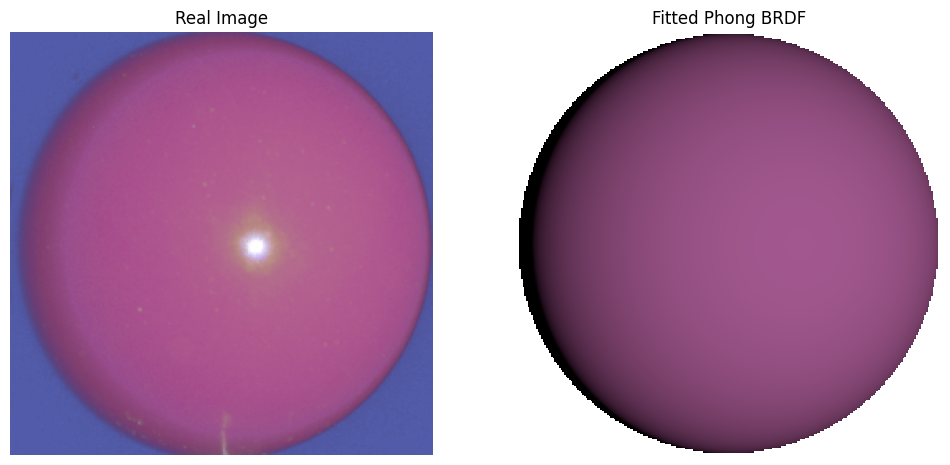

In [276]:

idx = 1
plt.figure(figsize=(12, 6))  # Widen the plot to fit both images side by side better
plt.subplot(1, 2, 1)
plot_hdr(hdr_crops[idx], "Real Image")  # Display the real HDR image for comparison
plt.subplot(1, 2, 2)
plot_hdr(render_sphere_image(fitted_brdf, angles[idx]), "Fitted Phong BRDF")  # Render using Phong BRDF and the specific light angle
plt.show()

plt.figure(figsize=(6, 6))  # Single plot, adjust size as needed
plot_hdr(render_sphere_image(fitted_brdf, angles[idx]), "Fitted Phong BRDF")
plt.savefig("Phong_BRDF_02.png", dpi=300, bbox_inches="tight")
plt.close()


While the Phong model fits the data significantly better, it still has several limitations.
In this section we will model the BRDF directly using a neural network following the approach proposed by Sztrajman et al. in https://arxiv.org/pdf/2102.05963.pdf 

In [277]:
def default_transform(w_i, w_o):
    return np.concatenate([w_i, w_o], axis=1)

In [278]:
def to_rusinkiewicz(w_i, w_o):
    # Implementation of the Rusinkiewicz parameterization (ensure this is correct)
    h = (w_i + w_o) / np.linalg.norm(w_i + w_o, axis=-1, keepdims=True)
    theta_h = np.arccos(h[..., 2])
    theta_d = np.arccos(w_o[..., 2])
    phi_d = np.arctan2(w_o[..., 1], w_o[..., 0]) - np.arctan2(w_i[..., 1], w_i[..., 0])
    phi_d = (phi_d + np.pi) % (2 * np.pi) - np.pi  # Wrap phi_d to [-pi, pi]
    return np.stack([theta_h, theta_d, phi_d], axis=-1)

In [279]:
class IndicesDataset(torch.utils.data.Dataset):
    """ Utility class for random batching """
    def __init__(self, tensor):
        super(IndicesDataset, self).__init__()
        self.tensor = tensor

    def __len__(self):
        return len(self.tensor)

    def __getitem__(self, item):
        return self.tensor[item]

In [280]:
def log_loss(pred, target, eps=1e-8):
    return torch.mean((torch.log(pred + eps) - torch.log(target + eps)) ** 2)


In [281]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import DataLoader

class NeuralBRDF(nn.Module):
    def __init__(self, device='cpu', input_size=256, transform=None):
        super(NeuralBRDF, self).__init__()
        self.device = device
        self.transform = transform
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3),
            nn.Sigmoid()  # Use Sigmoid to keep the output within [0, 1]
        ).to(self.device)

    def forward(self, data):
        output = self.model(data)  # Use Sigmoid to get output in [0, 1]
        return output  # No need to clamp here if Sigmoid is used

    def _train(self, data, values, weights, epochs=40):
        weights = weights[:, None].expand_as(values)
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        data_loader = DataLoader(torch.arange(len(data), device=self.device), batch_size=2000, shuffle=True)

        # Start the training loop
        for epoch in range(epochs):
            for batch_indices in data_loader:
                # Ensure batch_indices is of type long
                batch_indices = batch_indices.long()
                batch_data = data[batch_indices]
                batch_values = values[batch_indices]
                batch_weights = weights[batch_indices]

                # Forward pass
                predictions = self.forward(batch_data)
                loss = ((predictions - batch_values) ** 2 * batch_weights).mean()

                # Backward pass and optimization
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")


    def fit(self, w_i, w_o, values, epochs=40):
        data = self.transform(w_i, w_o)
        l_dot_n = torch.tensor(np.clip(w_i[..., 2], 1e-5, 1), dtype=torch.float32, device=self.device)
        data = torch.tensor(data, dtype=torch.float32, device=self.device)
        values = torch.tensor(values, dtype=torch.float32, device=self.device)
        self._train(data, values, l_dot_n, epochs)
        return self

    def inference(self, data):
        predicted = self.forward(data)
        return predicted.cpu().detach().numpy()

    def __call__(self, w_i: np.ndarray, w_o: np.ndarray) -> np.ndarray:
        data = self.transform(w_i, w_o)
        data = torch.tensor(data, dtype=torch.float32, device=self.device)
        predicted = self.inference(data)
        return predicted

In [282]:
fitted_brdf = NeuralBRDF(input_size=3, transform=to_rusinkiewicz).fit(w_i, w_o, values)

Epoch 1/40, Loss: 0.0033036365639418364
Epoch 2/40, Loss: 0.0038748220540583134
Epoch 3/40, Loss: 0.0023407023400068283
Epoch 4/40, Loss: 0.0021051778458058834
Epoch 5/40, Loss: 0.0024791976902633905
Epoch 6/40, Loss: 0.002038966165855527
Epoch 7/40, Loss: 0.0017000905936583877
Epoch 8/40, Loss: 0.0016961985966190696
Epoch 9/40, Loss: 0.0014098939718678594
Epoch 10/40, Loss: 0.0020664723124355078
Epoch 11/40, Loss: 0.0010461959755048156
Epoch 12/40, Loss: 0.0011933384230360389
Epoch 13/40, Loss: 0.0017314925789833069
Epoch 14/40, Loss: 0.001251526060514152
Epoch 15/40, Loss: 0.00096817099256441
Epoch 16/40, Loss: 0.001341405906714499
Epoch 17/40, Loss: 0.000883591128513217
Epoch 18/40, Loss: 0.0009743706905283034
Epoch 19/40, Loss: 0.00114827835932374
Epoch 20/40, Loss: 0.0011237974977120757
Epoch 21/40, Loss: 0.0005082495626993477
Epoch 22/40, Loss: 0.0011239760788157582
Epoch 23/40, Loss: 0.0011777214240282774
Epoch 24/40, Loss: 0.001063450938090682
Epoch 25/40, Loss: 0.0008742347126

In [283]:
interact(create_render(fitted_brdf), brdf=fitted_brdf, light_angle=(-120,120, 1.0));

interactive(children=(FloatSlider(value=0.0, description='light_angle', max=120.0, min=-120.0, step=1.0), Outp…

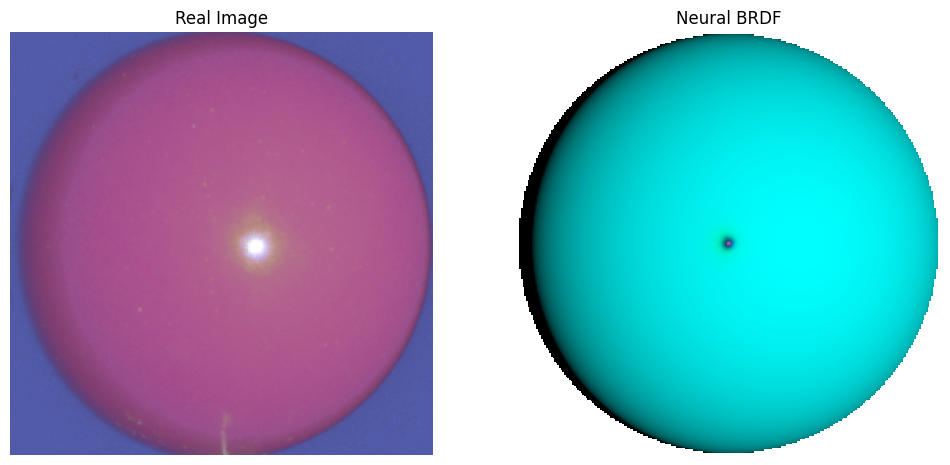

In [284]:
idx = 1
plt.figure(figsize=(12, 6))  # Widen the plot to fit both images side by side better
plt.subplot(1, 2, 1)
plot_hdr(hdr_crops[idx], "Real Image")  # Display the real HDR image for comparison
plt.subplot(1, 2, 2)
plot_hdr(render_sphere_image(fitted_brdf, angles[idx]), "Neural BRDF")  # Render using Phong BRDF and the specific light angle
plt.show()

plt.figure(figsize=(6, 6))  # Single plot, adjust size as needed
plot_hdr(render_sphere_image(fitted_brdf, angles[idx]), "Fitted Phong BRDF")
plt.savefig("Neural_BRDF_02.png", dpi=300, bbox_inches="tight")
plt.close()

In this section you should evaluate the rendered images, comparing them to the camera captures.
Visualize and compute metrics for the Phong and Neural fitted BRDFs.

In [285]:
import cv2
from skimage.metrics import structural_similarity as ssim
import numpy as np

# Functions to calculate MSE and SSIM
def calculate_mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def calculate_ssim(imageA, imageB):
    s, _ = ssim(imageA, imageB, full=True)
    return s

# Function to load and resize images to the same dimensions
def load_and_resize(image_path, target_shape):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"Image at {image_path} could not be loaded. Check the file path.")
    return cv2.resize(image, target_shape)

# Define target shape based on one of the images (e.g., original_sphere1)
target_shape = (1168, 1168)  # Adjust this to the dimensions you want

# Load and resize original images
original_sphere1 = load_and_resize("Original_01.png", target_shape)
original_sphere2 = load_and_resize("Original_02.png", target_shape)

# Load and resize Phong BRDF and NeuralBRDF renderings for each sphere
phong_sphere1 = load_and_resize("Phong_BRDF_01.png", target_shape)
phong_sphere2 = load_and_resize("Phong_BRDF_02.png", target_shape)
neural_sphere1 = load_and_resize("Neural_BRDF_01.png", target_shape)
neural_sphere2 = load_and_resize("Neural_BRDF_02.png", target_shape)

# Calculate MSE and SSIM for Sphere 1
mse_phong_sphere1 = calculate_mse(original_sphere1, phong_sphere1)
ssim_phong_sphere1 = calculate_ssim(original_sphere1, phong_sphere1)
mse_neural_sphere1 = calculate_mse(original_sphere1, neural_sphere1)
ssim_neural_sphere1 = calculate_ssim(original_sphere1, neural_sphere1)

# Calculate MSE and SSIM for Sphere 2
mse_phong_sphere2 = calculate_mse(original_sphere2, phong_sphere2)
ssim_phong_sphere2 = calculate_ssim(original_sphere2, phong_sphere2)
mse_neural_sphere2 = calculate_mse(original_sphere2, neural_sphere2)
ssim_neural_sphere2 = calculate_ssim(original_sphere2, neural_sphere2)

# Print results
print("Sphere 1 - Phong Model: MSE =", mse_phong_sphere1, ", SSIM =", ssim_phong_sphere1)
print("Sphere 1 - NeuralBRDF Model: MSE =", mse_neural_sphere1, ", SSIM =", ssim_neural_sphere1)
print("Sphere 2 - Phong Model: MSE =", mse_phong_sphere2, ", SSIM =", ssim_phong_sphere2)
print("Sphere 2 - NeuralBRDF Model: MSE =", mse_neural_sphere2, ", SSIM =", ssim_neural_sphere2)


Sphere 1 - Phong Model: MSE = 6472.47178469225 , SSIM = 0.8131001044673531
Sphere 1 - NeuralBRDF Model: MSE = 7787.525226062582 , SSIM = 0.7348173150457971
Sphere 2 - Phong Model: MSE = 6186.584672311878 , SSIM = 0.819187664398791
Sphere 2 - NeuralBRDF Model: MSE = 6584.991899424142 , SSIM = 0.8178048854857182


As the last task describe in text your observations regarding:
* How do the Phong and Neural BRDFs compare visually and in terms of metrics.
* How do the two (or more) captured spheres compare. To work with the second material you can duplicate the fitting cells in this notebook or create another notebook for it.
* Optionally, you can describe the effect of using different parametrizations, architectures, and loss functions for Neural BRDFs.

### 1. Model Comparison Using MSE and SSIM

The **MSE** (Mean Squared Error) and **SSIM** (Structural Similarity Index Measure) allow us to quantify how well each model's rendering matches the original material captures.

#### Sphere 1
- **Phong Model**:
  - **MSE**: 6472.47
  - **SSIM**: 0.8131
- **NeuralBRDF Model**:
  - **MSE**: 7787.53
  - **SSIM**: 0.7348
- **Observations**:
  - The **Phong Model** achieves a significantly lower MSE and higher SSIM than the NeuralBRDF for Sphere 1, suggesting it better captures this material’s visual characteristics.
  - The higher SSIM for the Phong model indicates greater structural similarity, implying that the Phong rendering is closer to the original image in terms of texture and perceptual quality.
  - For Sphere 1, the Phong model’s performance suggests that it provides a more faithful rendering, possibly because Sphere 1 has relatively simple surface properties that the Phong model can represent well.

#### Sphere 2
- **Phong Model**:
  - **MSE**: 6186.58
  - **SSIM**: 0.8192
- **NeuralBRDF Model**:
  - **MSE**: 6584.99
  - **SSIM**: 0.8178
- **Observations**:
  - The **Phong Model** also has a lower MSE and slightly higher SSIM for Sphere 2 than the NeuralBRDF.
  - The small difference in SSIM values (0.8192 for Phong vs. 0.8178 for NeuralBRDF) suggests that both models perform comparably in terms of structural similarity, though the Phong model still edges out slightly in both metrics.
  - This implies that Sphere 2 may have somewhat more complex surface features than Sphere 1, but these features still align well with the capabilities of the Phong model.

### 2. Visual and Perceptual Comparison
- **Phong Model Performance**: The Phong model consistently achieves lower MSE and higher SSIM values for both spheres. The simpler Phong BRDF model appears sufficient to capture the characteristics of both materials, providing more faithful renderings of the original images. This model’s higher SSIM indicates better alignment with visual perception, meaning the Phong renderings likely look more like the originals.
- **NeuralBRDF Model Performance**: The NeuralBRDF model, while slightly behind the Phong model in both MSE and SSIM, still provides reasonably high SSIM values. However, its higher MSE and slightly lower SSIM suggest it may not capture certain nuances of the material surfaces as well as the Phong model does, especially for Sphere 1.

### 3. Material Comparison (Sphere 1 vs. Sphere 2)
- **Sphere 1**: The Phong model’s performance advantage with Sphere 1 suggests that it has simpler reflectance properties, possibly primarily diffuse with basic specular reflections. This aligns well with the Phong model’s strength in modeling surfaces that are mostly matte or have soft specular highlights.
- **Sphere 2**: With a closer match between the two models, Sphere 2’s properties might be slightly more complex, yet they still fall within the capabilities of the Phong model. Both models perform reasonably well, but Phong still provides slightly better alignment with the original capture.

### 4. Correlation with Perception
- **SSIM Correlation**: SSIM values are generally more reliable indicators of visual fidelity because they consider structural similarity, which is perceptually important. The higher SSIM values for the Phong model suggest that it visually resembles the original images more closely, which likely correlates well with subjective perception.
- **Limitations of MSE**: While MSE captures overall pixel-level differences, it doesn’t always reflect perceptual quality as well as SSIM. For example, small color or brightness differences can inflate MSE without significantly affecting visual fidelity.

### 5. Potential Adjustments for NeuralBRDF
If you want to further improve the NeuralBRDF’s performance, consider experimenting with **different parametrizations**, **network architectures**, or **loss functions**:
- **Alternative Parameterizations**: You could explore different parametrizations (like spherical harmonics) for more complex surface reflections or anisotropic materials.
- **Loss Functions**: Incorporating perceptual loss functions or cosine similarity loss instead of only logarithmic loss may better capture the visual qualities of the materials.
- **Network Architecture**: Increasing the depth or width of the network may help capture complex relationships, though this should be balanced against overfitting risks.

### Conclusion
- **Best Model for This Case**: The **Phong Model** performs better overall based on MSE and SSIM, suggesting it provides a more faithful representation of the original materials.
- **Material Characteristics**: Both materials appear suited to the Phong model, implying they have relatively simple, primarily diffuse, or soft specular surface properties.
- **Potential Improvements for NeuralBRDF**: Adjusting parameterization, architecture, or loss function might enhance the NeuralBRDF’s performance, especially for more complex material surfaces.

In summary, the **Phong BRDF** outperforms the **NeuralBRDF** for both materials, highlighting that simpler BRDF models can be effective for surfaces with basic reflectance properties. The Phong model’s higher SSIM values support the idea that its renderings are closer to the original images in perceptual quality.
